# Chinese Dataset

Random Forest and XGBoost: Using Emsemble Machine Learning Algorithms to predict COVID-19 outcome.

Based on *'An interpretable mortality prediction model for
COVID-19 patients'*. Source [here](https://doi.org/10.1038/s42256-020-0180-7).

## Preps


### Import Libs

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from xgboost import plot_tree

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#plot in jupyter notebook
%matplotlib inline

In [2]:
#when using colab I like to do this to access the files in drive
#if running in a local pc: 
#           comment this cell
#           change the files' path
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Save Plots

In [94]:
save = 0   # save figs
#save = 1    # don't save figs

## Manipulating Data

### Read Data

Reading the dataset, dropping the *Admission* and *Discharge* times (not important) and then group by *Patient ID*.

In [95]:
df = pd.read_excel("gdrive/MyDrive/Bolsa - NeuroComp/datasets/time_series_375_prerpocess_en.xlsx",
                   index_col=[0,1])
df = df.drop(columns=['Admission time', 'Discharge time']) #info not important
df = df.groupby('PATIENT_ID').first()

df

,age,gender,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,73,1,0,19.9,136.0,103.1,13.9,0.09,0.6,NaN,46.0,33.3,0.3,NaN,8.3,105.0,10.7,NaN,NaN,4.3,11.9,65.8,69.3,0.05,91.0,0.03,91.8,39.2,3.54,NaN,347.0,3.28,NaN,8.50,0.80,7.415,4.27,0.02,2.29,4.33,7.35,2.33,4.0,11.9,634.9,40.8,19.2,22.6,0.06,2.20,3.90,33.0,418.0,21.2,2.02,60.0,306.0,39.9,NaN,NaN,0.38,16.3,36.0,24.0,1.06,0.01,-1.0,31.9,37.9,43.1,0.09,137.7,0.12,41.0,16.0,46.6,130.0
2,61,1,0,16.9,135.0,99.9,14.3,0.09,0.0,1152.0,33.0,35.3,0.1,35.9,9.1,290.0,3.2,NaN,29.6,4.9,12.1,89.2,70.5,0.06,87.0,0.00,90.8,38.4,7.46,12.3,352.0,5.58,5.0,6.10,0.56,6.000,4.23,0.00,2.49,4.78,5.91,6.65,4.2,10.4,1512.9,39.8,17.0,7.5,0.10,0.96,3.57,77.0,178.0,21.7,2.26,173.0,738.0,27.5,68.24,NaN,0.24,11.9,35.2,41.0,1.09,0.01,-1.0,31.9,42.3,27.4,NaN,138.2,0.30,40.0,38.0,81.3,88.0
3,70,2,0,NaN,109.0,99.1,13.6,0.06,0.0,591.0,47.0,34.9,0.0,8.1,7.5,169.0,5.9,84.0,21.9,3.8,12.8,75.0,68.3,0.07,94.0,0.01,94.6,33.2,3.72,10.4,328.0,5.33,5.0,2.90,0.71,NaN,3.51,0.00,2.17,3.34,9.02,2.79,3.7,11.6,567.2,44.4,16.7,19.1,0.06,0.98,3.28,30.0,151.0,22.3,2.07,NaN,328.0,37.8,47.82,4.0,0.22,13.9,33.4,21.0,1.04,0.00,-1.0,31.1,34.8,42.3,0.10,135.7,0.20,66.0,19.0,77.2,69.0
4,74,1,0,4.8,84.0,100.8,16.3,0.38,1.5,NaN,66.0,33.9,0.2,NaN,15.5,94.0,3.8,NaN,NaN,7.0,11.3,82.0,65.3,0.04,68.0,0.00,118.9,22.6,5.99,NaN,372.0,NaN,NaN,7.50,0.75,6.000,1.90,0.09,2.34,3.84,5.77,4.91,8.5,10.5,NaN,49.4,NaN,12.5,0.06,1.26,2.56,27.0,250.0,22.8,2.08,152.0,338.0,28.5,NaN,NaN,0.23,11.2,31.4,15.0,1.29,0.01,-1.0,44.2,NaN,108.2,0.11,137.9,0.10,72.0,20.0,82.0,81.0
5,29,2,0,5.6,120.0,99.7,14.6,0.02,0.2,258.0,78.0,40.2,0.2,5.0,3.5,215.0,6.8,NaN,16.6,1.6,12.5,54.9,70.3,0.05,83.0,0.01,86.8,34.9,4.43,11.1,344.0,NaN,16.4,2.30,1.68,6.000,4.02,0.01,2.26,3.26,5.34,2.43,1.9,10.3,121.1,40.0,NaN,37.9,0.05,0.42,2.49,24.0,302.0,25.6,2.12,5.0,195.0,26.7,1.50,NaN,0.30,11.4,30.1,19.0,1.13,0.01,-1.0,29.9,NaN,7.0,0.08,140.2,0.22,15.0,12.0,120.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,63,1,1,1741.5,143.0,95.7,14.4,1.51,0.0,758.0,65.0,30.7,0.0,39.6,7.1,149.0,5.5,NaN,21.6,2.9,11.9,79.5,64.0,NaN,86.0,NaN,87.9,41.3,5.12,8.7,346.0,5.48,5.0,5.30,0.77,NaN,4.70,0.00,2.34,3.89,7.07,4.07,4.2,10.9,2044.9,38.8,15.9,15.0,NaN,2.57,3.28,50.0,203.0,24.8,2.01,NaN,573.0,33.0,248.90

### Find NaN Values and Remove

Fiding NaN values in my dataset

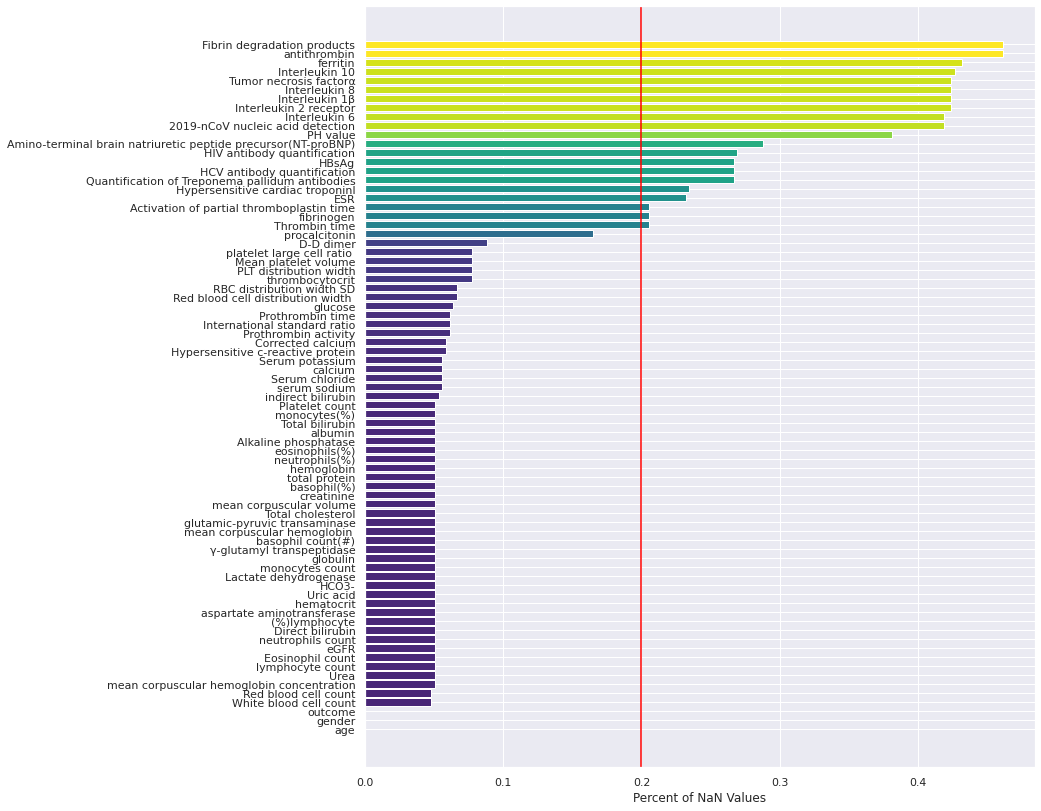

In [96]:
#find NaN values
miss_data = df.isna().mean().sort_values(ascending=True) 

#color func
my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

#plot 
fig, ax = plt.subplots(figsize=(12, 14))

#ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Percent of NaN Values')
plt.barh(miss_data.index, miss_data, color=my_cmap(rescale(miss_data)))
plt.axvline(0.2, color='red')

if (save == 0):
    plt.savefig('missing_data.png')

plt.show()

We're gonne use only data with less than 20% of NaN values (darker ones)

In [97]:
nan_value = 0.2 #percent of NaN values

df = df.loc[:, df.isnull().mean() < nan_value]
df

,age,gender,outcome,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Alkaline phosphatase,albumin,basophil(%),Total bilirubin,Platelet count,monocytes(%),indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Prothrombin activity,mean corpuscular volume,hematocrit,White blood cell count,mean corpuscular hemoglobin concentration,Urea,lymphocyte count,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,RBC distribution width SD,(%)lymphocyte,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Lactate dehydrogenase,platelet large cell ratio,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),mean corpuscular hemoglobin,Hypersensitive c-reactive protein,serum sodium,thrombocytocrit,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,73,1,0,136.0,103.1,13.9,0.09,0.6,46.0,33.3,0.3,8.3,105.0,10.7,4.3,11.9,65.8,69.3,91.0,91.8,39.2,3.54,347.0,8.50,0.80,4.27,0.02,2.29,4.33,7.35,2.33,4.0,11.9,40.8,22.6,2.20,3.90,33.0,418.0,21.2,2.02,306.0,39.9,0.38,16.3,36.0,24.0,1.06,0.01,31.9,43.1,137.7,0.12,16.0,46.6,130.0
2,61,1,0,135.0,99.9,14.3,0.09,0.0,33.0,35.3,0.1,9.1,290.0,3.2,4.9,12.1,89.2,70.5,87.0,90.8,38.4,7.46,352.0,6.10,0.56,4.23,0.00,2.49,4.78,5.91,6.65,4.2,10.4,39.8,7.5,0.96,3.57,77.0,178.0,21.7,2.26,738.0,27.5,0.24,11.9,35.2,41.0,1.09,0.01,31.9,27.4,138.2,0.30,38.0,81.3,88.0
3,70,2,0,109.0,99.1,13.6,0.06,0.0,47.0,34.9,0.0,7.5,169.0,5.9,3.8,12.8,75.0,68.3,94.0,94.6,33.2,3.72,328.0,2.90,0.71,3.51,0.00,2.17,3.34,9.02,2.79,3.7,11.6,44.4,19.1,0.98,3.28,30.0,151.0,22.3,2.07,328.0,37.8,0.22,13.9,33.4,21.0,1.04,0.00,31.1,42.3,135.7,0.20,19.0,77.2,69.0
4,74,1,0,84.0,100.8,16.3,0.38,1.5,66.0,33.9,0.2,15.5,94.0,3.8,7.0,11.3,82.0,65.3,68.0,118.9,22.6,5.99,372.0,7.50,0.75,1.90,0.09,2.34,3.84,5.77,4.91,8.5,10.5,49.4,12.5,1.26,2.56,27.0,250.0,22.8,2.08,338.0,28.5,0.23,11.2,31.4,15.0,1.29,0.01,44.2,108.2,137.9,0.10,20.0,82.0,81.0
5,29,2,0,120.0,99.7,14.6,0.02,0.2,78.0,40.2,0.2,3.5,215.0,6.8,1.6,12.5,54.9,70.3,83.0,86.8,34.9,4.43,344.0,2.30,1.68,4.02,0.01,2.26,3.26,5.34,2.43,1.9,10.3,40.0,37.9,0.42,2.49,24.0,302.0,25.6,2.12,195.0,26.7,0.30,11.4,30.1,19.0,1.13,0.01,29.9,7.0,140.2,0.22,12.0,120.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,63,1,1,143.0,95.7,14.4,1.51,0.0,65.0,30.7,0.0,7.1,149.0,5.5,2.9,11.9,79.5,64.0,86.0,87.9,41.3,5.12,346.0,5.30,0.77,4.70,0.00,2.34,3.89,7.07,4.07,4.2,10.9,38.8,15.0,2.57,3.28,50.0,203.0,24.8,2.01,573.0,33.0,0.28,13.1,33.3,27.0,1.10,0.00,30.4,152.0,135.8,0.16,31.0,88.6,81.0
372,79,1,1,115.0,111.5,17.4,2.13,0.2,136.0,19.6,0.1,26.1,120.0,4.9,0.4,15.4,93.2,53.8,60.0,94.5,36.4,13.40,316.0,26.80,0.21,3.85,0.03,2.45,5.68,8.48,12.49,25.7,12.6,53.1,1.6,1.21,2.63,31.0,450.0,18.4,1.90,276.0,44.5,0.66,15.6,34.2,363.0,1.40,0.01,29.9,320.0,147.0,0.15,40.0,13.7,345.0
373,61,2,1,100.0,102.6,14.9,0.56,0.1,141.0,23.9,0.1,9.0,136.0,4.5,4.1,13.9,89.0,60.8,77.0,80.9,29.3,12.13,341.0,5.20,0.76,3.62,0.01,2.29,4.22,8.53,10.80,4.9,12.9,38.7,6.3,NaN,2.57,31.0,84.2,25.4,1.97,702.0,46.1,0.55,19.7,36.9,39.0,1.18,0.01,27.6,205.8,141.6,0.18,9.0,101.3,47.0


Removing spaces 

In [98]:
df.columns = df.columns.str.replace(" ", "_")

### Separating Values

Separating the data set in features and labels



In [99]:
X = df.drop(columns=["outcome"])    #features
y = df.outcome                      #target 

## Frequent Functions

### Important Features Plot

In [100]:
def important_features_plot(imp, model_name, filename):
    #find more important values
    mi = imp.mean().sort_values(ascending=True) 

    #plot 
    fig, ax = plt.subplots(figsize=(12, 14))

    plt.title('Important Features: ' + model_name, fontsize=20)
    plt.xlabel('Mean of More Important Features', fontsize=10)

    sns.barplot(mi, mi.index)

    if (save==0):
        plt.savefig(filename)

    plt.show()

### Confusion Matrix Plot

In [101]:
def confusion_matrix_plot(cm, model_name, filename):
    #making labels
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    #plot
    fig, ax = plt.subplots(figsize=(12, 14))
    sns.heatmap(cm, annot=labels, fmt='', cmap="YlGnBu")#, cmap='viridis', cbar=True)
    ax.set_aspect('equal', adjustable='box')
    
    #axis labels
    ticks_labels = ['Survivals', 'Deaths']
    plt.xticks(np.arange(2) + .5, labels=ticks_labels, fontsize=14)
    plt.yticks(np.arange(2) + .5, labels=ticks_labels, fontsize=14)
    
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    
    #title
    plt.title('Confusion Matrix: '+ model_name, fontsize=30)

    if (save==0):
        plt.savefig(filename)
                
    #show
    plt.show()

### Decision Tree Plot

In [102]:
def decision_tree_plot(model, model_name, filename):
    fig = plt.figure(figsize=(16, 9))
    ax = plt.subplot(1,1,1)
            
    plot_tree(model, ax = ax)
    plt.title('Decision Tree: '+ model_name, fontsize=30)

    plt.tight_layout()
            
    if (save==0):
        plt.savefig(filename)

    plt.show()

## Training - Random Forest

XGBoost Read the Docs [[4]](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

XGBoost parameters [[5]](https://xgboost.readthedocs.io/en/latest/parameter.html)



In [103]:
import_feature_RF = pd.DataFrame(columns=X.columns)

tmax = 50 #100, 150, 200

for i in range(tmax): 
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=i) #state for iteration
    
    model_RF = XGBRFClassifier(max_depth=4,             #Maximum tree depth for base learners.
                               learning_rate=0.2,       #learning rate (“eta”)
                               reg_lambda=1,            #L2 regularization term on weights
                               n_estimators=150,        #Number of boosting rounds.
                               subsample = 0.9,         #Subsample ratio of the training instance.
                               colsample_bytree = 0.9)  #Subsample ratio of columns when constructing each tree.
    
    model_RF.fit(X_train, y_train)
    import_feature_RF = import_feature_RF.append(pd.DataFrame(model_RF.feature_importances_,
                                                              index=X.columns).transpose())

### Feature Importance

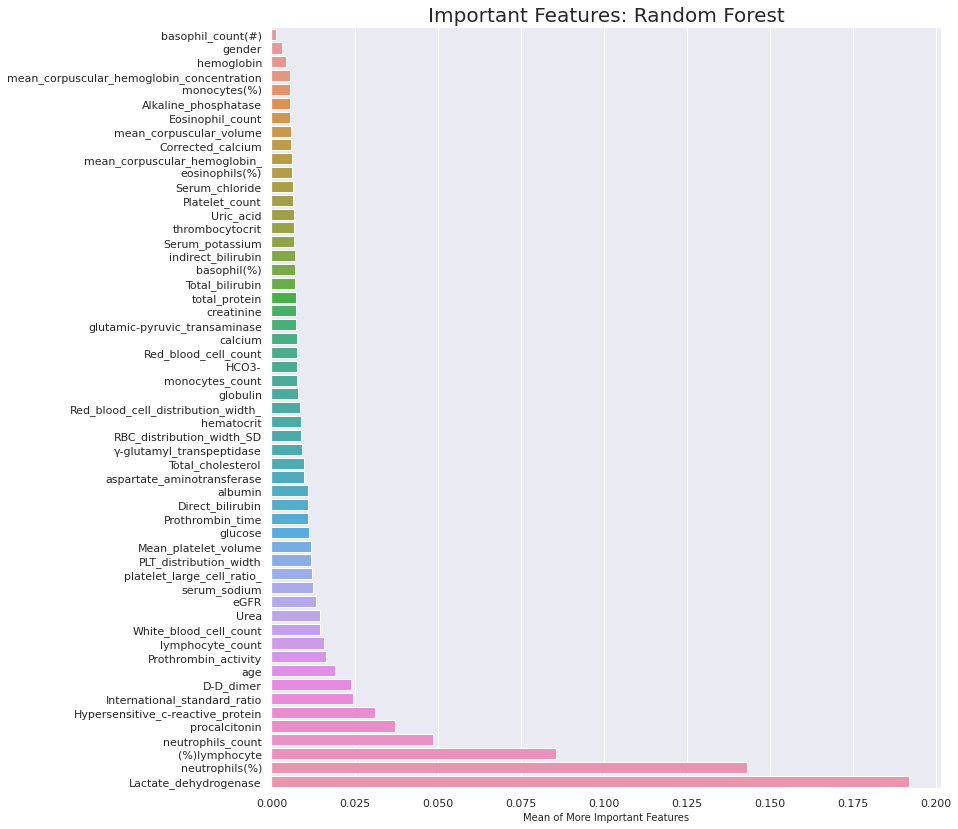

In [104]:
important_features_plot(import_feature_RF, 'Random Forest', 'imp_rf.png')

choosing the five best ones

In [105]:
X_best_RF = X[import_feature_RF.mean().sort_values(ascending=False).head(5).index]
X_best_RF

,Lactate_dehydrogenase,neutrophils(%),(%)lymphocyte,neutrophils_count,procalcitonin
PATIENT_ID,,,,,
1,306.0,65.8,22.6,2.33,0.09
2,738.0,89.2,7.5,6.65,0.09
3,328.0,75.0,19.1,2.79,0.06
4,338.0,82.0,12.5,4.91,0.38
5,195.0,54.9,37.9,2.43,0.02
...,...,...,...,...,...
371,573.0,79.5,15.0,4.07,1.51
372,276.0,93.2,1.6,12.49,2.13
373,702.0,89.0,6.3,10.80,0.56


### Evaluate Model

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_best_RF, #x = x_best
                                                    y, #same
                                                    test_size=0.3, #same
                                                    random_state=3463) #def state

model_RF = XGBRFClassifier(max_depth=4,
                           learning_rate=0.2,
                           reg_lambda=1,
                           n_estimators=150,
                           subsample=0.9,
                           colsample_bytree=0.9,
                           verbosity=0)

model_RF.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.9, gamma=0, learning_rate=0.2,
                max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
                n_estimators=150, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.9, verbosity=0)

### Predicting

In [107]:
predict_labels = model_RF.predict(X_test)
c_matrix_RF = confusion_matrix(y_test, predict_labels)

### Confusion Matrix

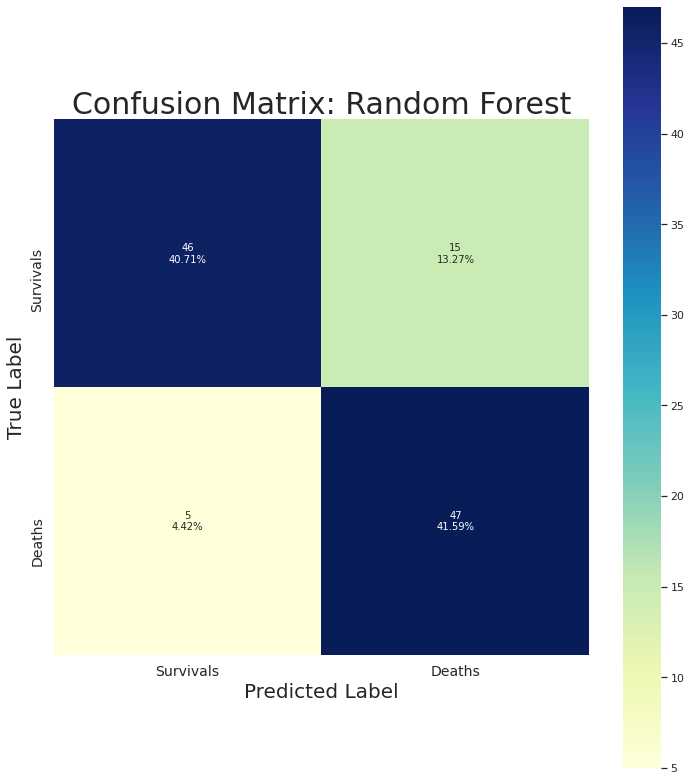

In [108]:
confusion_matrix_plot(c_matrix_RF, 'Random Forest', 'cm_rf.png')

### Model Reliability

F-score in wiki [here](https://en.wikipedia.org/wiki/F-score).

In [109]:
f1_score(y_test, predict_labels)

0.8245614035087719

saving for classification reports

In [110]:
y_test_RF, predict_labels_RF = y_test, predict_labels

### Tree Plot

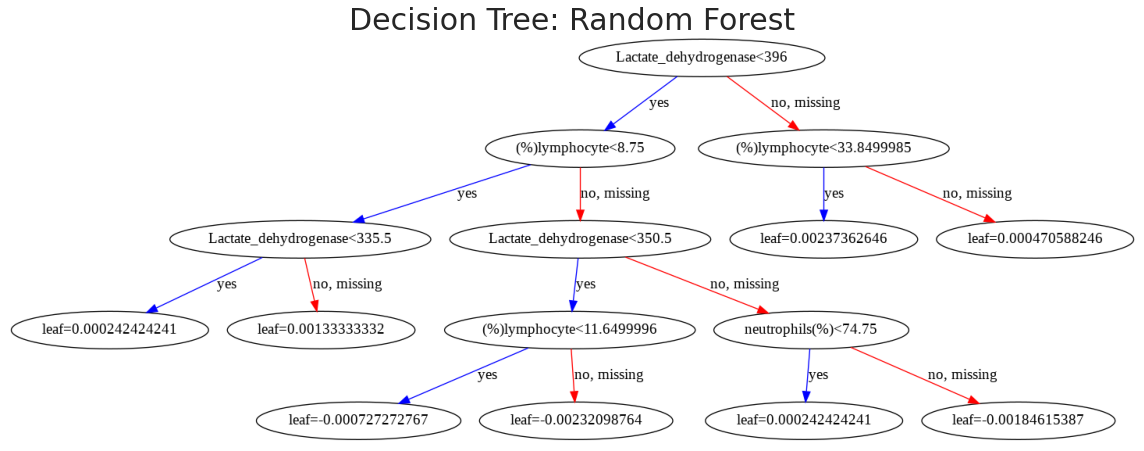

In [111]:
decision_tree_plot(model_RF, 'Random Forest', "tree_rf.png")

## Training - XGBoost

XGBoost Read the Docs [[4]](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

XGBoost parameters [[5]](https://xgboost.readthedocs.io/en/latest/parameter.html)



In [112]:
import_feature_XGB = pd.DataFrame(columns=X.columns)

tmax = 50 #100, 150, 200

for i in range(tmax): 
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=i) #state for iteration
    
    model_XGB = XGBClassifier(max_depth=4, #Maximum tree depth for base learners.
                              learning_rate=0.2, #learning rate (“eta”)
                              reg_lambda=1, #L2 regularization term on weights
                              n_estimators=150, #Number of boosting rounds.
                              subsample = 0.9, #Subsample ratio of the training instance.
                              colsample_bytree = 0.9) #Subsample ratio of columns when constructing each tree.
    
    model_XGB.fit(X_train, y_train)
    import_feature_XGB = import_feature_XGB.append(pd.DataFrame(model_XGB.feature_importances_,
                                                                index=X.columns).transpose())

### Feature Importance

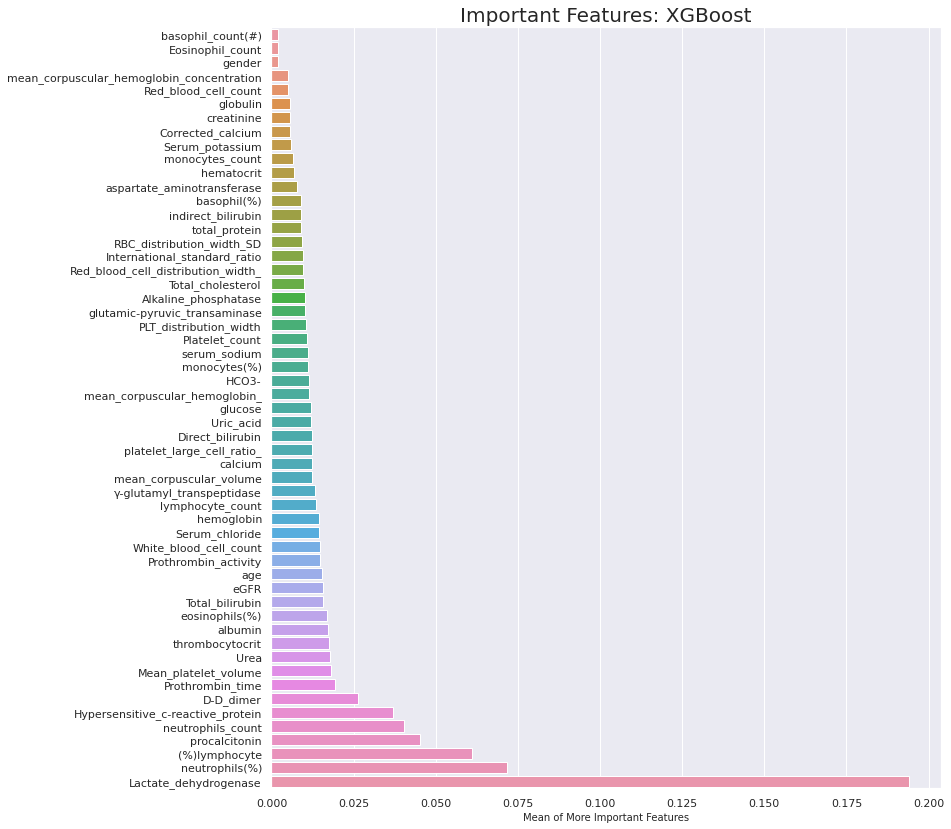

In [113]:
important_features_plot(import_feature_XGB, 'XGBoost', 'imp_xgb.png')

choosing the five best ones

In [114]:
X_best_XGB = X[import_feature_XGB.mean().sort_values(ascending=False).head(5).index]
X_best_XGB

,Lactate_dehydrogenase,neutrophils(%),(%)lymphocyte,procalcitonin,neutrophils_count
PATIENT_ID,,,,,
1,306.0,65.8,22.6,0.09,2.33
2,738.0,89.2,7.5,0.09,6.65
3,328.0,75.0,19.1,0.06,2.79
4,338.0,82.0,12.5,0.38,4.91
5,195.0,54.9,37.9,0.02,2.43
...,...,...,...,...,...
371,573.0,79.5,15.0,1.51,4.07
372,276.0,93.2,1.6,2.13,12.49
373,702.0,89.0,6.3,0.56,10.80


### Evaluate Model

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_best_XGB, #x = x_best
                                                    y, #same
                                                    test_size=0.3, #same
                                                    random_state=3463) #def state

model_XGB = XGBClassifier(max_depth=4,
                         learning_rate=0.2,
                         reg_lambda=1,
                         n_estimators=150,
                         subsample=0.9,
                         colsample_bytree=0.9,
                         verbosity=0)

model_XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=0)

### Predicting

In [116]:
predict_labels = model_XGB.predict(X_test)
c_matrix_XGB = confusion_matrix(y_test, predict_labels)

### Confusion Matrix

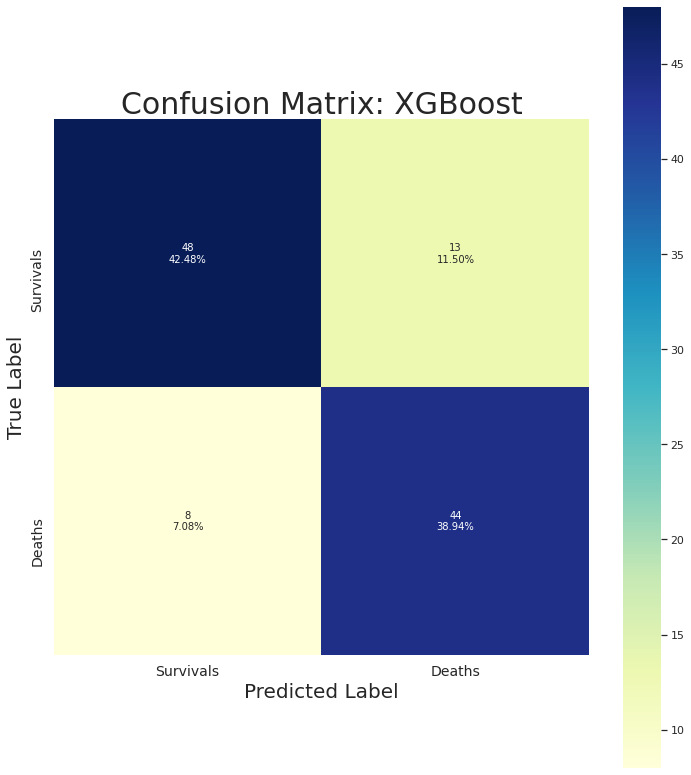

In [117]:
confusion_matrix_plot(c_matrix_XGB, 'XGBoost', 'cm_xgb.png')

### Model Reliability

F-score in wiki [here](https://en.wikipedia.org/wiki/F-score).

In [118]:
f1_score(y_test, predict_labels)

0.8073394495412844

saving for classification reports

In [119]:
y_test_XGB, predict_labels_XGB = y_test, predict_labels

### Tree Plot

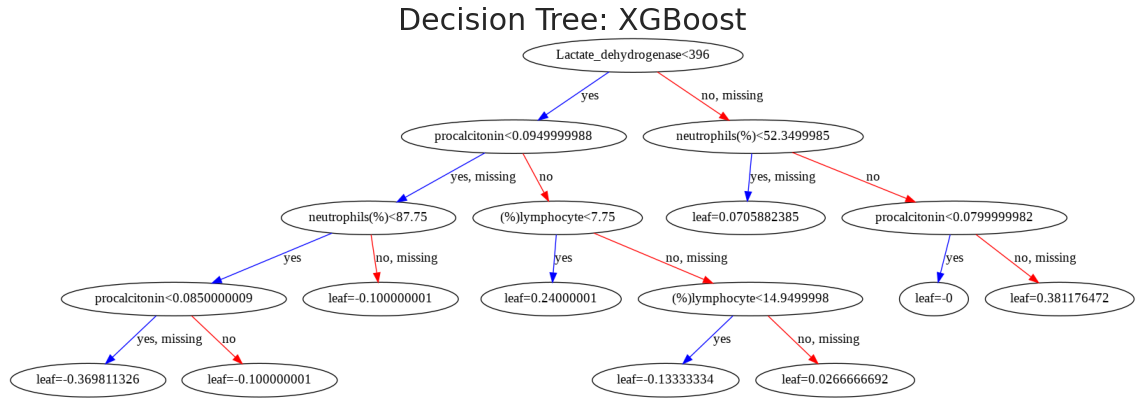

In [120]:
decision_tree_plot(model_XGB, 'XGBoost', "tree_xgb.png")

## Classification Reports

### Theory

Comparision between both methods.

Precision (column):
\begin{aligned}
    P = \frac{TP}{TP + FP}
\end{aligned}

Recall (row):
\begin{aligned}
    R = \frac{TP}{TP+FN}
\end{aligned}

F1-Score (model confiability):
\begin{aligned}
    F1 = 2 \frac{R \cdot P}{R+P} = \frac{TP}{TP+FN+FP}
\end{aligned}

Where $TP$ is True-Positive, $TN$ is True-Negative, $FP$ is False-Positive and $FN$ is False-Negative.

### Random Forest

In [121]:
print("Random Forest")
print("")
print("Classification Report")
print("---------------------")
print(classification_report(y_test_RF, predict_labels_RF, target_names=['Survivals', 'Deaths']))
print("Confusion Matrix")
print("----------------")
print(c_matrix_RF)

Random Forest

Classification Report
---------------------
              precision    recall  f1-score   support

   Survivals       0.90      0.75      0.82        61
      Deaths       0.76      0.90      0.82        52

    accuracy                           0.82       113
   macro avg       0.83      0.83      0.82       113
weighted avg       0.84      0.82      0.82       113

Confusion Matrix
----------------
[[46 15]
 [ 5 47]]


### XGBoost

In [122]:
1385
print("Classification Report")
print("---------------------")
print(classification_report(y_test_XGB, predict_labels_XGB, target_names=['Survivals', 'Deaths']))
print("Confusion Matrix")
print("----------------")
print(c_matrix_XGB)

Classification Report
---------------------
              precision    recall  f1-score   support

   Survivals       0.86      0.79      0.82        61
      Deaths       0.77      0.85      0.81        52

    accuracy                           0.81       113
   macro avg       0.81      0.82      0.81       113
weighted avg       0.82      0.81      0.81       113

Confusion Matrix
----------------
[[48 13]
 [ 8 44]]
